基于上午的代码进一步改进

In [1]:
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime

# 创建输出目录
if not os.path.exists('output_data'):
    os.makedirs('output_data')

# 仿真参数
NUM_HOPS = 101
SIMULATION_TIME = 60  # 仿真时间(秒)
TIME_STEP = 0.001  # 时间步长(秒)
SYNC_INTERVAL = 1.0  # 同步消息发送间隔(秒)

# 网络和时钟参数
MAX_LINK_DELAY = 0.0001  # 最大链路延迟(秒)
MAX_JITTER = 0.00001  # 最大抖动(秒)
MAX_DRIFT_RATE = 0.00001  # 最大时钟漂移率(秒/秒)
TIMESTAMP_ERROR = 0.000001  # 时间戳误差(秒)

class Node:
    def __init__(self, node_id, initial_time=0, drift_rate=0):
        self.node_id = node_id
        self.local_time = initial_time
        self.drift_rate = drift_rate
        self.offset_from_gm = 0  # 相对于Grandmaster的偏移
        self.history = []  # 保存时间同步历史
    
    def update_local_time(self, time_step):
        # 更新本地时钟，考虑漂移
        self.local_time += time_step * (1 + self.drift_rate)
        
    def sync_time(self, master_time, path_delay):
        # 计算偏移并调整本地时钟
        time_offset = master_time + path_delay - self.local_time
        self.offset_from_gm = time_offset
        self.local_time += time_offset
        self.history.append(self.offset_from_gm)
        return time_offset

def simulate_gptp():
    # 初始化节点
    nodes = []
    # 创建Grandmaster节点(第0跳)
    grandmaster = Node(0, initial_time=0, drift_rate=0)  # Grandmaster没有漂移
    nodes.append(grandmaster)
    
    # 创建100个从节点(1-100跳)
    for i in range(1, NUM_HOPS + 1):
        # 随机初始化时钟偏移和漂移率
        initial_offset = random.uniform(-0.001, 0.001)
        drift_rate = random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        node = Node(i, initial_time=initial_offset, drift_rate=drift_rate)
        nodes.append(node)
    
    # 准备保存数据 - 只为1-100跳保存数据
    results = {f"hop_{i}": [] for i in range(1, NUM_HOPS + 1)}
    
    # 仿真时间步进
    current_time = 0
    next_sync_time = 0
    
    while current_time < SIMULATION_TIME:
        # 更新每个节点的本地时钟
        for node in nodes:
            node.update_local_time(TIME_STEP)
        
        # 执行gPTP同步
        if current_time >= next_sync_time:
            # 从Grandmaster开始的累积延迟
            cumulative_delay = 0
            
            # Grandmaster的时间
            gm_time = nodes[0].local_time
            
            # 沿着链路传播同步消息
            for i in range(1, NUM_HOPS + 1):
                # 计算链路延迟(包括抖动)
                link_delay = random.uniform(0, MAX_LINK_DELAY) + random.uniform(-MAX_JITTER, MAX_JITTER)
                cumulative_delay += link_delay
                
                # 一步模式：直接将Grandmaster时间戳+累积延迟传递给从节点
                # 添加时间戳误差
                timestamp_err = random.uniform(-TIMESTAMP_ERROR, TIMESTAMP_ERROR)
                master_time = gm_time + timestamp_err
                
                # 从节点进行时间同步
                offset = nodes[i].sync_time(master_time, cumulative_delay)
                
                # 记录偏移结果
                results[f"hop_{i}"].append(offset)
            
            # 设置下一个同步时间点
            next_sync_time = current_time + SYNC_INTERVAL
        
        # 推进仿真时间
        current_time += TIME_STEP
    
    # 保存结果到CSV
    df = pd.DataFrame(results)
    csv_path = os.path.join('output_data', f'gptp_sync_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
    df.to_csv(csv_path, index=False)
    
    print(f"仿真完成，结果已保存到: {csv_path}")
    return df

if __name__ == "__main__":
    results = simulate_gptp()

仿真完成，结果已保存到: output_data\gptp_sync_results_20250423_214906.csv


In [4]:
import numpy as np
import pandas as pd
import os
import random
from datetime import datetime

# 创建输出目录
if not os.path.exists('output_data'):
    os.makedirs('output_data')

# 仿真参数 - 基于论文设置
NUM_HOPS = 100  # 100跳网络
SIMULATION_TIME = 100  # 仿真时间(秒)
TIME_STEP = 0.001  # 时间步长(秒)
SYNC_INTERVAL = 0.03125  # 同步消息发送间隔(秒) - 31.25ms，符合论文

# 网络和时钟参数 - 基于论文设置
MAX_LINK_DELAY = 0.000050  # 链路延迟(秒) - 50ns
MAX_PHY_JITTER = 0.000000008  # 最大PHY抖动(秒) - 8ns
MAX_DRIFT_RATE = 0.000010  # 最大时钟漂移率(秒/秒) - 10ppm
CLOCK_GRANULARITY = 0.000000008  # 时钟粒度(秒) - 8ns
RESIDENCE_TIME = 0.001  # 最大驻留时间(秒) - 1ms
PDELAY_INTERVAL = 1.0  # 传播延迟测量间隔(秒) - 1s
NEIGHBOR_RATE_RATIO_ERROR = 0.0000001  # 邻居速率比误差 - 0.1ppm

class Node:
    def __init__(self, node_id, initial_time=0, drift_rate=0):
        self.node_id = node_id
        self.local_time = initial_time
        self.drift_rate = drift_rate
        self.offset_from_gm = 0  # 相对于Grandmaster的偏移
        self.sync_history = []  # 保存时间同步历史
        
        # 传播延迟测量相关
        self.propagation_delay = MAX_LINK_DELAY
        self.last_pdelay_measurement_time = 0
        
        # 邻居速率比
        self.neighbor_rate_ratio = 1.0
        
        # 修正场
        self.correction_field = 0
    
    def update_local_time(self, time_step):
        # 更新本地时钟，考虑漂移
        self.local_time += time_step * (1 + self.drift_rate)
    
    def measure_propagation_delay(self):
        # 模拟传播延迟测量，公式(27): Di = D0 + 2J + g
        true_delay = MAX_LINK_DELAY
        phy_jitter = random.uniform(0, MAX_PHY_JITTER * 2)  # 两个PHY抖动之和
        granularity_error = random.uniform(0, CLOCK_GRANULARITY)
        self.propagation_delay = true_delay + phy_jitter + granularity_error
        return self.propagation_delay
    
    def sync_time(self, gm_time):
        # 根据论文中的同步过程
        # 应用公式(3): GM(t_R_i) = O + C_i−1 + D_i−1
        # 其中O是GM发出同步消息的时间戳，即gm_time
        # C_i-1是修正场，包含了路径上的累积延迟
        # D_i-1是传播延迟
        
        # 计算偏移并调整本地时钟
        synchronized_time = gm_time + self.correction_field
        time_offset = synchronized_time - self.local_time
        self.offset_from_gm = time_offset
        self.local_time += time_offset
        self.sync_history.append(self.offset_from_gm)
        return self.offset_from_gm

def simulate_gptp():
    # 初始化节点
    nodes = []
    
    # 创建Grandmaster节点(第0跳)
    grandmaster = Node(0, initial_time=0, drift_rate=0)  # Grandmaster没有漂移
    nodes.append(grandmaster)
    
    # 创建100个从节点(1-100跳)
    for i in range(1, NUM_HOPS + 1):
        # 随机初始化时钟偏移和漂移率
        initial_offset = random.uniform(-0.0000001, 0.0000001)  # ±100ns
        drift_rate = random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
        node = Node(i, initial_time=initial_offset, drift_rate=drift_rate)
        nodes.append(node)
    
    # 准备保存数据 - 为1-100跳保存数据
    results = {f"hop_{i}": [] for i in range(1, NUM_HOPS + 1)}
    
    # 初始化传播延迟测量
    for i in range(1, NUM_HOPS + 1):
        nodes[i].measure_propagation_delay()
    
    # 仿真时间步进
    current_time = 0
    next_sync_time = 0
    
    while current_time < SIMULATION_TIME:
        # 更新每个节点的本地时钟
        for node in nodes:
            node.update_local_time(TIME_STEP)
        
        # 周期性执行传播延迟测量
        for i in range(1, NUM_HOPS + 1):
            if current_time >= nodes[i].last_pdelay_measurement_time + PDELAY_INTERVAL:
                nodes[i].measure_propagation_delay()
                nodes[i].last_pdelay_measurement_time = current_time
        
        # 执行gPTP同步 - 同步锁定模式(syncLocked)
        if current_time >= next_sync_time:
            # Grandmaster的时间
            gm_time = nodes[0].local_time
            
            # 沿着链路传播同步消息，每个节点依次同步
            for i in range(1, NUM_HOPS + 1):
                # 获取节点和它的上游节点
                prev_node = nodes[i-1]
                curr_node = nodes[i]
                
                # 计算节点间速率比，添加测量误差
                true_ratio = (1 + prev_node.drift_rate) / (1 + curr_node.drift_rate)
                ratio_error = random.uniform(-NEIGHBOR_RATE_RATIO_ERROR, NEIGHBOR_RATE_RATIO_ERROR)
                curr_node.neighbor_rate_ratio = true_ratio + ratio_error
                
                # 模拟传播延迟和驻留时间
                propagation_delay = curr_node.propagation_delay
                residence_time = random.uniform(0, RESIDENCE_TIME)
                
                # PHY抖动影响
                phy_jitter = random.uniform(0, MAX_PHY_JITTER)
                
                # 计算修正场 - 根据论文公式(2)
                # C_i = C_i−1 + D_i−1 + (t_S_i − t_R_i)r_i
                if i == 1:
                    # 第一个节点使用传播延迟作为初始修正场
                    curr_node.correction_field = propagation_delay
                else:
                    # 其他节点根据前一个节点的修正场、传播延迟和驻留时间计算
                    curr_node.correction_field = prev_node.correction_field + \
                                               propagation_delay + \
                                               (residence_time * curr_node.neighbor_rate_ratio)
                
                # 添加时间戳误差
                timestamp_error = phy_jitter + random.uniform(0, CLOCK_GRANULARITY)
                curr_node.correction_field += timestamp_error
                
                # 从节点进行时间同步
                offset = curr_node.sync_time(gm_time)
                
                # 记录偏移结果
                results[f"hop_{i}"].append(abs(offset))
            
            # 设置下一个同步时间点
            next_sync_time = current_time + SYNC_INTERVAL
        
        # 推进仿真时间
        current_time += TIME_STEP
    
    # 保存结果到CSV
    df = pd.DataFrame(results)
    csv_path = os.path.join('output_data', f'gptp_sync_results_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
    df.to_csv(csv_path, index=False)
    
    print(f"仿真完成，结果已保存到: {csv_path}")
    print(f"时间同步精度统计:")
    
    # 输出精度统计
    for i in [10, 30, 50, 100]:  # 关键节点
        offsets = results[f"hop_{i}"]
        max_offset = max(offsets) if offsets else 0
        avg_offset = sum(offsets) / len(offsets) if offsets else 0
        within_1us = sum(1 for x in offsets if x < 0.000001) / len(offsets) * 100 if offsets else 0
        print(f"节点 {i}: 最大偏移 = {max_offset*1e6:.3f} μs, 平均偏移 = {avg_offset*1e6:.3f} μs, 在1μs内概率 = {within_1us:.1f}%")
    
    return df

if __name__ == "__main__":
    results = simulate_gptp()

仿真完成，结果已保存到: output_data\gptp_sync_results_20250423_224543.csv
时间同步精度统计:
节点 10: 最大偏移 = 4699.856 μs, 平均偏移 = 992.274 μs, 在1μs内概率 = 0.1%
节点 30: 最大偏移 = 16906.146 μs, 平均偏移 = 1769.557 μs, 在1μs内概率 = 0.1%
节点 50: 最大偏移 = 29075.387 μs, 平均偏移 = 2261.551 μs, 在1μs内概率 = 0.0%
节点 100: 最大偏移 = 56688.389 μs, 平均偏移 = 3234.845 μs, 在1μs内概率 = 0.0%


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
100 跳 IEEE 802.1AS one‐step gPTP 时间同步仿真
输出：每一跳的同步偏差（秒）保存在 output_data/offsets.csv 中，
每一列对应一个跳数（hop1, hop2, …, hop100）。
参考：Gutierrez 等, "Synchronization Quality of IEEE 802.1AS in Large-Scale Industrial Automation Networks", 2017.
"""
import os
import csv
import math
import random

# 仿真参数
N_HOPS       = 100            # 跳数
D0           = 62e-9          # 每跳线缆传播延迟（秒）
J_MAX        = 8e-9           # PHY 抖动上限（秒）
G            = 8e-9           # 时钟粒度（秒）
TAU          = 1e-3           # 驻留时间（秒）
DRIFT_PPM    = 10e-6          # 时钟漂移最大值（±10 ppm）
NR_ERR_PPM   = 0.1e-6         # 邻居比率测量误差最大值（±0.1 ppm）

# 随机种子（可选，便于重现）
random.seed(42)

# 输出目录及文件
out_dir = "output_data"
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, "offsets.csv")

# 初始化数组
rho   = [0.0] * (N_HOPS+1)  # 每跳真实时钟漂移率
r     = [0.0] * (N_HOPS+1)  # 累计速率比
C     = [0.0] * (N_HOPS+1)  # 校正域
t_ref_send = [0.0] * (N_HOPS+1)  # 参考时钟下的“发送”时间
offset = [0.0] * (N_HOPS+1)      # 每跳的本地 vs GM 时钟偏差

# Grandmaster (跳 0) 参数
rho[0]       = 0.0    # 假设 grandmaster 漂移为 0（理想）
r[0]         = 1.0
C[0]         = 0.0
t_ref_send[0]= 0.0

# 仿真一次同步过程
for i in range(1, N_HOPS+1):
    # 1) 取随机抖动
    J_i = random.uniform(0, J_MAX)

    # 2) 真实参考时钟下到达时间
    t_ref_arr = t_ref_send[i-1] + D0 + J_i

    # 3) 本地时钟漂移率 rho[i] ~ U(-DRIFT_PPM, +DRIFT_PPM)
    rho[i] = random.uniform(-DRIFT_PPM, DRIFT_PPM)

    # 4) 邻居速率比测量误差
    delta_nr = random.uniform(-NR_ERR_PPM, NR_ERR_PPM)

    # 5) 完美邻居速率比 + 误差
    perfect_nri = (1.0 + rho[i-1]) / (1.0 + rho[i])
    nri = perfect_nri + delta_nr

    # 6) 更新累计速率比
    r[i] = r[i-1] * nri

    # 7) 本地时钟在到达时刻的读数并量化
    t_local_arr_raw = (1.0 + rho[i]) * t_ref_arr
    t_local_arr = math.floor(t_local_arr_raw / G) * G

    # 8) 驻留后“发送”时间（参考时钟）
    t_ref_send[i] = t_ref_arr + TAU

    # 9) 本地时钟在发送时刻的读数并量化
    t_local_send_raw = (1.0 + rho[i]) * t_ref_send[i]
    t_local_send = math.floor(t_local_send_raw / G) * G

    # 10) 更新校正域
    #     C[i] = C[i-1] + D0 + (t_S - t_R) * r[i]
    C[i] = C[i-1] + D0 + (t_local_send - t_local_arr) * r[i]

    # 11) 记录到达时刻的偏差（arrival offset before correction）
    #     GM_time = O + C[i-1] + D0, 这里 O=0
    GM_time = C[i-1] + D0
    offset[i] = t_local_arr - GM_time

# 将结果写入 CSV，每列一跳
with open(out_csv, "w", newline='') as f:
    writer = csv.writer(f)
    # 写表头
    header = [f"hop{i}" for i in range(1, N_HOPS+1)]
    writer.writerow(header)
    # 写一行数据
    row = [offset[i] for i in range(1, N_HOPS+1)]
    writer.writerow(row)

print(f"仿真完成，偏差数据已保存到 {out_csv}")

仿真完成，偏差数据已保存到 output_data\offsets.csv


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
60s 时长、100 跳 IEEE 802.1AS one‐step gPTP 时间同步仿真
输出：每次同步（行）在每一跳（列）的同步偏差（秒），保存在 output_data/offsets.csv
参考：Gutierrez 等, "Synchronization Quality of IEEE 802.1AS in Large-Scale Industrial Automation Networks", 2017.
"""
import os
import csv
import math
import random

# ─── 仿真参数 ─────────────────────────────────────────────
N_HOPS        = 100            # 跳数
SIM_TIME      = 60.0           # 仿真总时长 (s)
SYNC_INTERVAL = 31.25e-3       # 同步间隔 (31.25 ms)
D0            = 62e-9          # 每跳线缆传播延迟 (秒)
J_MAX         = 8e-9           # PHY 抖动上限 (秒)
G             = 8e-9           # 时钟粒度 (秒)
TAU           = 1e-3           # 驻留时间 (秒)
DRIFT_PPM     = 10e-6          # 时钟漂移最大值 (±10 ppm)
NR_ERR_PPM    = 0.1e-6         # 邻居比率测量误差最大值 (±0.1 ppm)

random.seed(42)                # 固定随机种子以复现

# 计算要做的同步次数
n_syncs = int(SIM_TIME / SYNC_INTERVAL)

# 输出目录及文件
out_dir = "output_data"
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, "offsets.csv")

# ─── 初始化每跳固定参数 ───────────────────────────────────
# drift rates ρ[i] 恒定不变，i=0 为 grandmaster
rho = [0.0] + [random.uniform(-DRIFT_PPM, DRIFT_PPM) for _ in range(N_HOPS)]
# 存放全部同步轮次的偏差：rows=轮次, cols=跳号
all_offsets = [[0.0]*N_HOPS for _ in range(n_syncs)]

# ─── 主循环：每次 Sync ───────────────────────────────────
for sync_idx in range(n_syncs):
    # 跳 0（grandmaster）发送参考时刻
    t_ref_send_prev = sync_idx * SYNC_INTERVAL
    C_prev = 0.0       # correctionField 清零
    r_prev = 1.0       # 累计速率比
    
    # 逐跳传播
    for i in range(1, N_HOPS+1):
        # 1) 每跳随机 PHY 抖动
        J_i = random.uniform(0, J_MAX)
        # 2) 参考时钟到达时间
        t_ref_arr = t_ref_send_prev + D0 + J_i
        # 3) 本地时钟速率比：r_prev * nri
        #    先测量带误差的邻居速率比 nri
        perfect_nri = (1.0 + rho[i-1]) / (1.0 + rho[i])
        delta_nr   = random.uniform(-NR_ERR_PPM, NR_ERR_PPM)
        nri        = perfect_nri + delta_nr
        # 4) 更新累计速率比
        r_i = r_prev * nri
        # 5) 本地时钟到达时刻读数并量化
        t_local_arr = math.floor(((1.0 + rho[i]) * t_ref_arr)/G)*G
        # 6) 驻留 TAU 后的参考发送时刻
        t_ref_send = t_ref_arr + TAU
        # 7) 本地时钟发送时刻读数并量化
        t_local_send = math.floor(((1.0 + rho[i]) * t_ref_send)/G)*G
        # 8) 更新校正域 C[i]
        C_i = C_prev + D0 + (t_local_send - t_local_arr)*r_i
        # 9) 记录偏差：arrival offset = t_local_arr - GM_time
        #    GM_time = O + C_prev + D0，O=0
        GM_time     = C_prev + D0
        offset      = t_local_arr - GM_time
        all_offsets[sync_idx][i-1] = offset
        
        # 为下一跳准备
        t_ref_send_prev = t_ref_send
        C_prev          = C_i
        r_prev          = r_i

# ─── 将结果写入 CSV ─────────────────────────────────────────
with open(out_csv, "w", newline='') as f:
    writer = csv.writer(f)
    # 写表头
    header = [f"hop{i}" for i in range(1, N_HOPS+1)]
    writer.writerow(header)
    # 写每次同步的 N_HOPS 列偏差
    writer.writerows(all_offsets)

print(f"仿真完成 ({SIM_TIME}s/{n_syncs} 次同步)。")
print(f"偏差矩阵已保存到：{out_csv}")

仿真完成 (60.0s/1920 次同步)。
偏差矩阵已保存到：output_data\offsets.csv


In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
60s 时长、100 跳 IEEE 802.1AS one‐step gPTP 时间同步仿真
定义：
    time_error = local_time_at_arrival - GM_time_at_that_instant
输出：
    CSV 文件 output_data/offsets.csv
    - 每行：一次 Sync（共 SIM_TIME/SYNC_INTERVAL 行）
    - 每列：hop1…hop100 的 time_error（单位：秒）
参考：Gutierrez 等, "Synchronization Quality of IEEE 802.1AS in Large-Scale Industrial Automation Networks", 2017.
"""
import os
import csv
import math
import random

# ─── 仿真参数 ─────────────────────────────────────────────
N_HOPS        = 100            # 跳数
SIM_TIME      = 60.0           # 仿真总时长 (s)
SYNC_INTERVAL = 31.25e-3       # 同步间隔 31.25 ms
D0            = 62e-9          # 每跳线缆传播延迟 (s)
J_MAX         = 8e-9           # PHY 抖动上限 (s)
G             = 8e-9           # 时钟粒度 (s)
TAU           = 1e-3           # 驻留时间 (s)
DRIFT_PPM     = 10e-6          # 时钟漂移最大值 ±10 ppm
NR_ERR_PPM    = 0.1e-6         # 邻居速率比测量误差 ±0.1 ppm

random.seed(42)                # 固定随机种子以复现

# 要做的同步次数
n_syncs = int(SIM_TIME / SYNC_INTERVAL)

# 输出目录及文件
out_dir = "output_data"
os.makedirs(out_dir, exist_ok=True)
out_csv = os.path.join(out_dir, "offsets.csv")

# ─── 初始化：为每个节点分配一个“真实”漂移率 ρ[i] ───────────────
# 节点 0 作为 Grandmaster，ρ[0]=0；其余 ρ[i] 随机 ∈ [-DRIFT_PPM, +DRIFT_PPM]
rho = [0.0] + [random.uniform(-DRIFT_PPM, DRIFT_PPM) for _ in range(N_HOPS)]

# 存放所有同步轮次的 time_error：rows = 轮次, cols = 跳号
all_time_errors = [[0.0]*N_HOPS for _ in range(n_syncs)]

# ─── 主循环：每次 Sync ───────────────────────────────────
for sync_idx in range(n_syncs):
    # 跳 0（Grandmaster）在 t = sync_idx*SYNC_INTERVAL 发出 Sync
    t_ref_send_prev = sync_idx * SYNC_INTERVAL
    C_prev = 0.0   # 前一跳的 correctionField
    r_prev = 1.0   # 前一跳的 累计速率比

    # 逐跳传播
    for i in range(1, N_HOPS+1):
        # 1) 随机 PHY 抖动 J_i
        J_i = random.uniform(0, J_MAX)

        # 2) 参考时钟到达时间
        t_ref_arr = t_ref_send_prev + D0 + J_i

        # 3) 邻居速率比 nri = perfect_nri + 测量误差
        perfect_nri = (1.0 + rho[i-1]) / (1.0 + rho[i])
        delta_nr   = random.uniform(-NR_ERR_PPM, NR_ERR_PPM)
        nri        = perfect_nri + delta_nr

        # 4) 更新累计速率比
        r_i = r_prev * nri

        # 5) 本地时钟到达时刻读数并量化（量化误差 = 时钟粒度 G）
        t_local_arr = math.floor(((1.0 + rho[i]) * t_ref_arr) / G) * G

        # 6) 驻留 TAU 后的下一跳参考发送时刻
        t_ref_send = t_ref_arr + TAU

        # 7) 本地时钟发送时刻读数并量化
        t_local_send = math.floor(((1.0 + rho[i]) * t_ref_send) / G) * G

        # 8) 更新 correctionField C_i
        C_i = C_prev + D0 + (t_local_send - t_local_arr) * r_i

        # 9) 计算 time_error 并记录
        #    GM_time = O + C_prev + D0  （O = 0）
        GM_time     = C_prev + D0
        time_error  = t_local_arr - GM_time
        all_time_errors[sync_idx][i-1] = time_error

        # 10) 为下一跳更新状态
        t_ref_send_prev = t_ref_send
        C_prev          = C_i
        r_prev          = r_i

# ─── 写入 CSV ─────────────────────────────────────────────
with open(out_csv, "w", newline='') as f:
    writer = csv.writer(f)
    # 表头：hop1 … hop100
    header = [f"hop{i}_error" for i in range(1, N_HOPS+1)]
    writer.writerow(header)
    # 每行：一次 Sync 的 100 个 time_error（单位：秒）
    writer.writerows(all_time_errors)

print(f"仿真完成：{SIM_TIME}s，共 {n_syncs} 次同步")
print(f"time_error 矩阵已保存到：{out_csv}")

仿真完成：60.0s，共 1920 次同步
time_error 矩阵已保存到：output_data\offsets.csv


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
60s 时长、100 跳 IEEE 802.1AS one‐step gPTP 时间同步仿真
time_error = local_time_at_arrival - true_GM_time_at_arrival
"""
import os, csv, math, random

# 参数同前……
N_HOPS, SIM_TIME = 100, 60.0
SYNC_INTERVAL    = 31.25e-3
D0, J_MAX, G     = 62e-9, 8e-9, 8e-9
TAU              = 1e-3
DRIFT_PPM        = 10e-6
NR_ERR_PPM       = 0.1e-6

random.seed(42)
n_syncs = int(SIM_TIME / SYNC_INTERVAL)

rho = [0.0] + [random.uniform(-DRIFT_PPM, DRIFT_PPM) for _ in range(N_HOPS)]
all_errors = [[0.0]*N_HOPS for _ in range(n_syncs)]

for sync_idx in range(n_syncs):
    t_ref_send_prev = sync_idx * SYNC_INTERVAL
    C_prev, r_prev = 0.0, 1.0

    for i in range(1, N_HOPS+1):
        J_i = random.uniform(0, J_MAX)
        t_ref_arr = t_ref_send_prev + D0 + J_i

        perfect_nri = (1.0 + rho[i-1]) / (1.0 + rho[i])
        nri        = perfect_nri + random.uniform(-NR_ERR_PPM, NR_ERR_PPM)
        r_i        = r_prev * nri

        t_local_arr = math.floor(((1.0 + rho[i]) * t_ref_arr) / G) * G

        t_ref_send  = t_ref_arr + TAU
        t_local_send= math.floor(((1.0 + rho[i]) * t_ref_send) / G) * G

        C_i = C_prev + D0 + (t_local_send - t_local_arr) * r_i

        # ←— 这里用真实的 GM 时间 t_ref_arr 来计算误差
        time_error          = t_local_arr - t_ref_arr
        all_errors[sync_idx][i-1] = time_error

        # 更新
        t_ref_send_prev = t_ref_send
        C_prev, r_prev  = C_i, r_i

out_dir = "output_data"
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, "offsets.csv"), "w", newline="") as f:
    w = csv.writer(f)
    w.writerow([f"hop{i}_error" for i in range(1, N_HOPS+1)])
    w.writerows(all_errors)

print("仿真完成，time_error 已保存到 output_data/offsets.csv")

仿真完成，time_error 已保存到 output_data/offsets.csv


In [9]:
import csv
import random

# 仿真参数
NUM_NODES = 100  # 节点数量
SYNC_INTERVAL = 31.25e-3  # 同步间隔（秒）
PHY_JITTER_MAX = 8e-9  # PHY抖动（秒）
CLOCK_GRANULARITY = 8e-9  # 时钟粒度（秒）
DRIFT_RATE_MAX = 10e-6  # 最大时钟漂移速率（ppm）
SIMULATION_TIME = 100  # 模拟时间（秒）
INITIAL_DRIFT = [-DRIFT_RATE_MAX, DRIFT_RATE_MAX]  # 初始漂移范围（ppm）

# 初始化节点的时钟状态
class Node:
    def __init__(self, node_id):
        self.node_id = node_id
        self.local_time = 0.0  # 节点本地时间
        self.drift_rate = random.uniform(*INITIAL_DRIFT)  # 每个节点的漂移率
        self.time_error = 0.0  # 同步误差

# 计算传播延迟
def calculate_propagation_delay():
    # 假设传播延迟为恒定值 + 抖动，平均值为50ns
    base_delay = 50e-9
    jitter = random.uniform(0, PHY_JITTER_MAX)
    return base_delay + jitter

# 计算时钟同步误差
def synchronize_clock(node, upstream_node, propagation_delay):
    # 更新时间偏差
    correction = propagation_delay + random.uniform(0, CLOCK_GRANULARITY)
    node.time_error = upstream_node.time_error + correction

# 运行仿真
def run_simulation():
    # 初始化节点
    nodes = [Node(i) for i in range(NUM_NODES)]

    # 创建一个CSV文件，写入结果
    with open("time_errors.csv", mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Node ID", "Time Error (s)"])

        # 仿真时间循环
        for t in range(int(SIMULATION_TIME / SYNC_INTERVAL)):
            for i in range(1, NUM_NODES):
                propagation_delay = calculate_propagation_delay()
                synchronize_clock(nodes[i], nodes[i - 1], propagation_delay)

            # 每个同步周期记录一次所有节点的时间误差
            for node in nodes:
                writer.writerow([node.node_id, node.time_error])

# 主函数
if __name__ == "__main__":
    print("Starting IEEE 802.1AS Simulation...")
    run_simulation()
    print("Simulation complete. Results saved to 'time_errors.csv'.")

Starting IEEE 802.1AS Simulation...
Simulation complete. Results saved to 'time_errors.csv'.


Running simulation with 100 nodes for 100 seconds...
Running propagation delay measurements...
Running sync message propagation (3200 intervals)...
Processed 100/3200 intervals (1.4s elapsed)
Processed 200/3200 intervals (2.4s elapsed)
Processed 300/3200 intervals (3.4s elapsed)
Processed 400/3200 intervals (4.3s elapsed)
Processed 500/3200 intervals (5.3s elapsed)
Processed 600/3200 intervals (6.3s elapsed)
Processed 700/3200 intervals (7.2s elapsed)
Processed 800/3200 intervals (8.2s elapsed)
Processed 900/3200 intervals (9.2s elapsed)
Processed 1000/3200 intervals (10.1s elapsed)
Processed 1100/3200 intervals (11.1s elapsed)
Processed 1200/3200 intervals (12.0s elapsed)
Processed 1300/3200 intervals (13.0s elapsed)
Processed 1400/3200 intervals (14.0s elapsed)
Processed 1500/3200 intervals (14.9s elapsed)
Processed 1600/3200 intervals (15.9s elapsed)
Processed 1700/3200 intervals (16.9s elapsed)
Processed 1800/3200 intervals (17.8s elapsed)
Processed 1900/3200 intervals (18.8s elaps

KeyError: 100

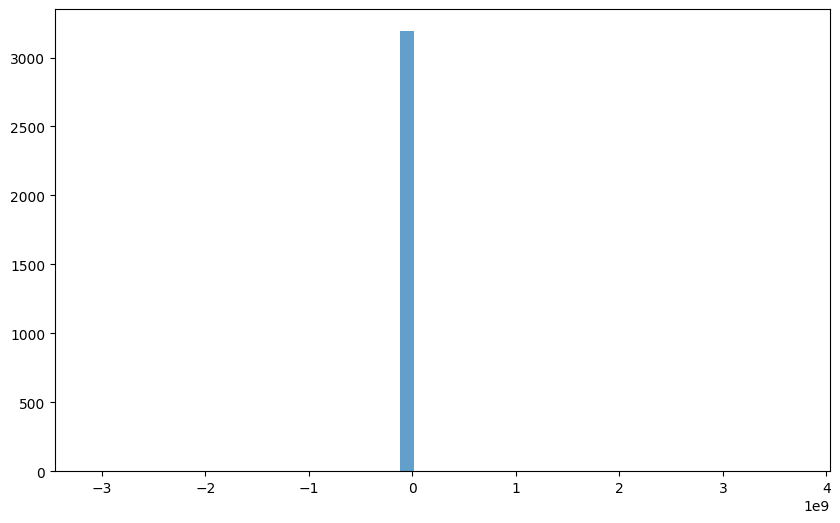

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import time

class Clock:
    """
    Clock model with drift and granularity as described in the paper.
    """
    def __init__(self, initial_drift_ppm=None, granularity_ns=8):
        # Set initial drift rate between -10 and 10 ppm if not specified
        if initial_drift_ppm is None:
            self.drift_rate_ppm = random.uniform(-10, 10)
        else:
            self.drift_rate_ppm = initial_drift_ppm
        
        # Initial drift rate (for reference)
        self.initial_drift_ppm = self.drift_rate_ppm
        
        # Initialize time to 0
        self.time = 0
        
        # Clock granularity in nanoseconds (8ns as per paper)
        self.granularity_ns = granularity_ns
        
        # Rate of change of drift rate (up to 1 ppm/s)
        self.drift_rate_change_ppm_per_s = random.uniform(0, 1)
    
    def advance(self, delta_t_s):
        """
        Advance clock by delta_t_s seconds, considering drift.
        """
        # Update drift rate due to changes over time (eq. 7-8 in paper)
        self.drift_rate_ppm += self.drift_rate_change_ppm_per_s * delta_t_s
        
        # Calculate actual time advancement with drift (eq. 6 in paper)
        actual_delta = delta_t_s * (1 + self.drift_rate_ppm / 1e6)
        
        # Add to current time
        self.time += actual_delta
        
        # Apply granularity effect
        granularity_s = self.granularity_ns / 1e9
        self.time = round(self.time / granularity_s) * granularity_s
        
        return self.time
    
    def get_time(self):
        """
        Return current time with granularity effect.
        """
        granularity_s = self.granularity_ns / 1e9
        return round(self.time / granularity_s) * granularity_s
    
    def adjust(self, offset):
        """
        Adjust clock by adding offset.
        """
        self.time += offset
        
        # Apply granularity
        granularity_s = self.granularity_ns / 1e9
        self.time = round(self.time / granularity_s) * granularity_s


class TimeAwareSystem:
    """
    Represents a time-aware system in an IEEE 802.1AS network.
    """
    def __init__(self, node_id, is_grandmaster=False):
        self.node_id = node_id
        self.is_grandmaster = is_grandmaster
        self.clock = Clock()
        
        # Propagation delay measurement
        self.propagation_delay = 0
        self.propagation_delay_measurements = deque(maxlen=10)
        
        # IEEE 802.1AS synchronization parameters
        self.correction_field = 0
        self.rate_ratio = 1.0
        self.neighbor_rate_ratio = 1.0
        
        # Sync message timestamps (tR and tS in Figure 1)
        self.t_receive = 0  
        self.t_send = 0     
        
        # For measuring synchronization precision
        self.time_deviations = []
        
        # Origin timestamp from grandmaster
        self.origin_timestamp = 0
        
        # Neighbor rate ratio measurement error (±0.1 ppm as per paper)
        self.neighbor_rate_ratio_error = random.uniform(-0.1, 0.1) / 1e6
    
    def calculate_neighbor_rate_ratio(self, neighbor_drift_rate_ppm):
        """
        Calculate neighbor rate ratio based on drift rates with error.
        Using equation (26) from the paper.
        """
        # Calculate ideal neighbor rate ratio
        ideal_ratio = (1 + neighbor_drift_rate_ppm / 1e6) / (1 + self.clock.drift_rate_ppm / 1e6)
        
        # Add error to simulate measurement inaccuracy (±0.1 ppm)
        self.neighbor_rate_ratio = ideal_ratio + self.neighbor_rate_ratio_error
        
        return self.neighbor_rate_ratio
    
    def measure_propagation_delay(self, neighbor):
        """
        Simulate propagation delay measurement as per Fig. 2 in the paper.
        """
        # Base propagation delay (50 ns for 10m copper wire)
        base_delay_ns = 50
        
        # PHY jitter for each timestamp (0-8 ns, uniformly distributed)
        phy_jitter1 = random.uniform(0, 8) / 1e9
        phy_jitter2 = random.uniform(0, 8) / 1e9
        phy_jitter3 = random.uniform(0, 8) / 1e9
        phy_jitter4 = random.uniform(0, 8) / 1e9
        
        # Simulate Pdelay_Req message (timestamps as in Fig. 2)
        t1 = self.clock.get_time()
        
        # Add propagation delay and PHY jitter for message transmission
        propagation_time = base_delay_ns / 1e9 + phy_jitter1
        
        # Advance both clocks by propagation time
        self.clock.advance(propagation_time)
        neighbor.clock.advance(propagation_time)
        
        # Neighbor receives Pdelay_Req
        t2 = neighbor.clock.get_time()
        
        # Simulate processing time in neighbor
        processing_time = random.uniform(0, 1e-6)  # Up to 1 μs
        neighbor.clock.advance(processing_time)
        self.clock.advance(processing_time)
        
        # Neighbor sends Pdelay_Resp
        t3 = neighbor.clock.get_time()
        
        # Add propagation delay and PHY jitter for response
        propagation_time = base_delay_ns / 1e9 + phy_jitter3
        
        # Advance both clocks by propagation time
        self.clock.advance(propagation_time)
        neighbor.clock.advance(propagation_time)
        
        # Receive Pdelay_Resp
        t4 = self.clock.get_time()
        
        # Calculate propagation delay using equation (4) from the paper
        measured_delay = 0.5 * ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2))
        
        # Store measurement
        self.propagation_delay_measurements.append(measured_delay)
        
        # Use cumulative average as the propagation delay value (as mentioned in paper)
        self.propagation_delay = sum(self.propagation_delay_measurements) / len(self.propagation_delay_measurements)
        
        return self.propagation_delay
    
    def receive_sync(self, origin_timestamp, correction_field, rate_ratio, neighbor_drift_rate_ppm):
        """
        Process a received Sync message and update clock based on IEEE 802.1AS.
        """
        # Record receive timestamp
        self.t_receive = self.clock.get_time()
        
        # Store origin timestamp
        self.origin_timestamp = origin_timestamp
        
        # Calculate neighbor rate ratio
        self.calculate_neighbor_rate_ratio(neighbor_drift_rate_ppm)
        
        # Update rate ratio using equation (1) from the paper
        self.rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # Store the correction field from the received sync message
        self.correction_field = correction_field
        
        # Calculate GM time using equation (3) from the paper
        gm_time = origin_timestamp + correction_field + self.propagation_delay
        
        # Calculate time deviation before correction
        time_deviation = self.clock.get_time() - gm_time
        self.time_deviations.append(time_deviation)
        
        # Adjust clock to synchronize with grandmaster
        self.clock.adjust(-time_deviation)
        
        return time_deviation
    
    def send_sync(self):
        """
        Send a Sync message with updated time synchronization information.
        Returns the time synchronization information for the next node.
        """
        # Record send timestamp
        self.t_send = self.clock.get_time()
        
        # Update correction field using equation (2) from the paper
        residence_time = self.t_send - self.t_receive
        new_correction = self.correction_field + self.propagation_delay + (residence_time * self.rate_ratio)
        
        # Return time synchronization information
        return self.origin_timestamp, new_correction, self.rate_ratio


class IEEE8021ASSimulation:
    """
    Simulation of IEEE 802.1AS in a chain topology.
    """
    def __init__(self, num_nodes=100, sync_interval_ms=31.25, pdelay_interval_s=1):
        # Network parameters (as per paper)
        self.num_nodes = num_nodes
        self.sync_interval_s = sync_interval_ms / 1000.0
        self.pdelay_interval_s = pdelay_interval_s
        
        # Create time-aware systems
        self.nodes = []
        for i in range(num_nodes):
            is_gm = (i == 0)
            self.nodes.append(TimeAwareSystem(i, is_gm))
        
        # Results storage
        self.time_deviations = {i: [] for i in range(num_nodes)}
        
        # Store initial drift rates for analysis
        self.initial_drift_rates = [node.clock.initial_drift_ppm for node in self.nodes]
    
    def run(self, simulation_time_s=100):
        """
        Run the simulation for the specified time.
        """
        start_time = time.time()
        
        # Number of sync intervals to simulate
        num_intervals = int(simulation_time_s / self.sync_interval_s)
        
        # Number of pdelay intervals
        num_pdelay = int(simulation_time_s / self.pdelay_interval_s)
        
        print(f"Running propagation delay measurements...")
        # Run propagation delay measurements first
        for p in range(num_pdelay):
            for i in range(1, self.num_nodes):
                self.nodes[i].measure_propagation_delay(self.nodes[i-1])
                
                # Advance all clocks to keep time synchronized during measurement phase
                for node in self.nodes:
                    node.clock.advance(self.pdelay_interval_s / (self.num_nodes - 1))
        
        print(f"Running sync message propagation ({num_intervals} intervals)...")
        # Run simulation for specified time
        for interval in range(num_intervals):
            if interval % 100 == 0 and interval > 0:
                elapsed = time.time() - start_time
                print(f"Processed {interval}/{num_intervals} intervals ({elapsed:.1f}s elapsed)")
            
            # Advance all clocks by sync interval
            for node in self.nodes:
                node.clock.advance(self.sync_interval_s)
            
            # Grandmaster initiates sync
            origin_timestamp = self.nodes[0].clock.get_time()
            correction_field = 0
            rate_ratio = 1.0
            
            # Propagate sync through the network (syncLocked mode)
            for i in range(1, self.num_nodes):
                # Calculate PHY jitter for sync message (0-8 ns)
                phy_jitter = random.uniform(0, 8) / 1e9
                
                # Base propagation delay
                propagation_delay_s = 50 / 1e9  # 50 ns
                
                # Advance clocks by propagation time + jitter
                for node in self.nodes:
                    node.clock.advance(propagation_delay_s + phy_jitter)
                
                # Node receives sync
                time_deviation = self.nodes[i].receive_sync(
                    origin_timestamp,
                    correction_field,
                    rate_ratio,
                    self.nodes[i-1].clock.drift_rate_ppm
                )
                
                # Store time deviation for analysis
                self.time_deviations[i].append(time_deviation)
                
                # Node processes sync and prepares to forward (residence time)
                residence_time = random.uniform(0, 1e-3)  # Up to 1 ms as per paper
                
                # Advance clocks by residence time
                for node in self.nodes:
                    node.clock.advance(residence_time)
                
                # Node sends updated sync
                origin_timestamp, correction_field, rate_ratio = self.nodes[i].send_sync()
        
        elapsed = time.time() - start_time
        print(f"Simulation completed in {elapsed:.1f} seconds")
    
    def calculate_synchronization_probability(self, precision_threshold):
        """
        Calculate probability of synchronization within the given precision threshold.
        """
        probabilities = {}
        
        for i in range(1, self.num_nodes):
            if not self.time_deviations[i]:
                continue
            
            deviations = self.time_deviations[i]
            in_sync = sum(1 for d in deviations if abs(d) < precision_threshold)
            probability = in_sync / len(deviations)
            probabilities[i] = probability
        
        return probabilities
    
    def plot_time_deviation_distribution(self, node_ids=None):
        """
        Plot distribution of time deviations for specific nodes.
        """
        if node_ids is None:
            node_ids = [self.num_nodes - 1]  # Last node by default
        elif isinstance(node_ids, int):
            node_ids = [node_ids]
        
        plt.figure(figsize=(10, 6))
        
        for node_id in node_ids:
            # Convert to nanoseconds for better readability
            deviations_ns = [d * 1e9 for d in self.time_deviations[node_id]]
            
            plt.hist(deviations_ns, bins=50, alpha=0.7, label=f"Node {node_id}")
            
            # Calculate statistics
            mean_dev = np.mean(deviations_ns)
            max_dev = max(abs(d) for d in deviations_ns)
            
            print(f"Node {node_id} statistics:")
            print(f"  Mean deviation: {mean_dev:.2f} ns")
            print(f"  Max absolute deviation: {max_dev:.2f} ns")
        
        plt.title("Time Deviation Distribution")
        plt.xlabel("Time Deviation (ns)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_synchronization_probability(self, precision_thresholds):
        """
        Plot synchronization probability for different precision thresholds.
        """
        plt.figure(figsize=(10, 6))
        
        for threshold in precision_thresholds:
            probs = self.calculate_synchronization_probability(threshold)
            nodes = sorted(probs.keys())
            probabilities = [probs[n] for n in nodes]
            
            # Convert threshold to ns for the label
            threshold_ns = threshold * 1e9
            plt.plot(nodes, probabilities, '-', label=f"Precision < {threshold_ns:.0f} ns")
        
        plt.title("Probability of Synchronization")
        plt.xlabel("Node ID (Distance from Grandmaster)")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.show()
    
    def plot_precision_vs_hops(self):
        """
        Plot the maximum time deviation as a function of hops from grandmaster.
        """
        max_deviations = {}
        mean_deviations = {}
        
        for i in range(1, self.num_nodes):
            if not self.time_deviations[i]:
                continue
            
            # Calculate statistics in ns
            devs_ns = [abs(d) * 1e9 for d in self.time_deviations[i]]
            max_deviations[i] = max(devs_ns)
            mean_deviations[i] = np.mean(devs_ns)
        
        plt.figure(figsize=(10, 6))
        
        plt.plot(list(max_deviations.keys()), list(max_deviations.values()), 'ro-', label='Maximum Deviation')
        plt.plot(list(mean_deviations.keys()), list(mean_deviations.values()), 'bo-', label='Mean Deviation')
        
        plt.title("Time Deviation vs. Number of Hops")
        plt.xlabel("Node ID (Distance from Grandmaster)")
        plt.ylabel("Time Deviation (ns)")
        plt.legend()
        plt.grid(True)
        plt.show()


# Run the simulation
def main():
    # Create simulation with 100 nodes (as in the paper)
    num_nodes = 100
    sim = IEEE8021ASSimulation(num_nodes=num_nodes, sync_interval_ms=31.25)
    
    # Run for 100 seconds (as in the paper)
    print(f"Running simulation with {num_nodes} nodes for 100 seconds...")
    sim.run(simulation_time_s=100)
    
    # Plot results
    print("Plotting results...")
    
    # Plot time deviation distribution for node 10 and node 100
    sim.plot_time_deviation_distribution([10, 100])
    
    # Plot synchronization probability for different precision thresholds
    precision_thresholds = [0.5e-6, 1e-6, 2e-6]  # 0.5 μs, 1 μs, 2 μs
    sim.plot_synchronization_probability(precision_thresholds)
    
    # Plot precision vs number of hops
    sim.plot_precision_vs_hops()
    
    print("Simulation completed.")

if __name__ == "__main__":
    main()

Running simulation with 100 nodes for 100 seconds...
Running propagation delay measurements...
Running sync message propagation (3200 intervals)...
Processed 100/3200 intervals (1.5s elapsed)
Processed 200/3200 intervals (2.6s elapsed)
Processed 300/3200 intervals (3.7s elapsed)
Processed 400/3200 intervals (4.7s elapsed)
Processed 500/3200 intervals (6.1s elapsed)
Processed 600/3200 intervals (7.0s elapsed)
Processed 700/3200 intervals (8.0s elapsed)
Processed 800/3200 intervals (9.0s elapsed)
Processed 900/3200 intervals (10.0s elapsed)
Processed 1000/3200 intervals (10.9s elapsed)
Processed 1100/3200 intervals (11.9s elapsed)
Processed 1200/3200 intervals (12.9s elapsed)
Processed 1300/3200 intervals (13.9s elapsed)
Processed 1400/3200 intervals (14.9s elapsed)
Processed 1500/3200 intervals (15.9s elapsed)
Processed 1600/3200 intervals (16.8s elapsed)
Processed 1700/3200 intervals (17.8s elapsed)
Processed 1800/3200 intervals (18.8s elapsed)
Processed 1900/3200 intervals (19.7s elap

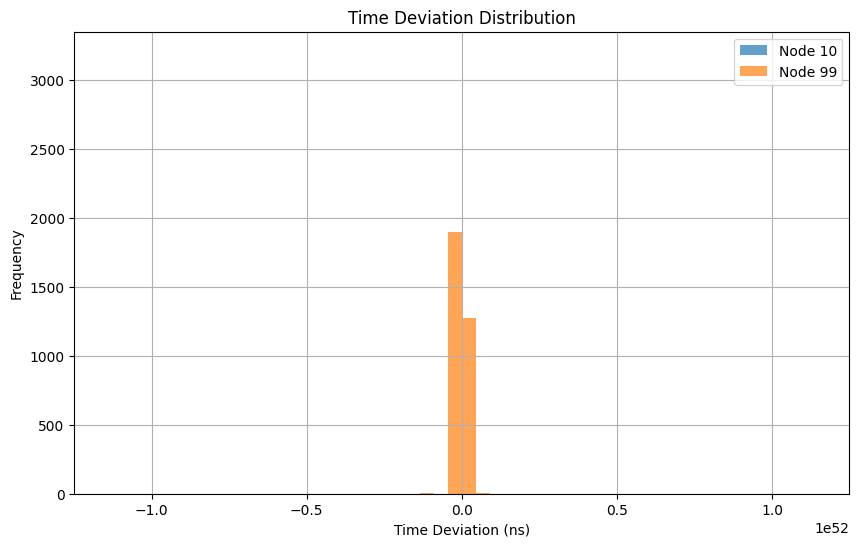

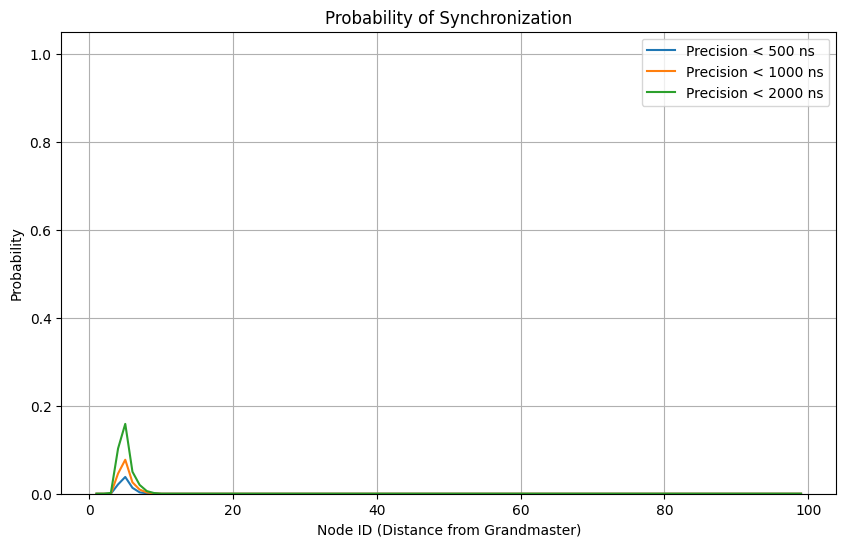

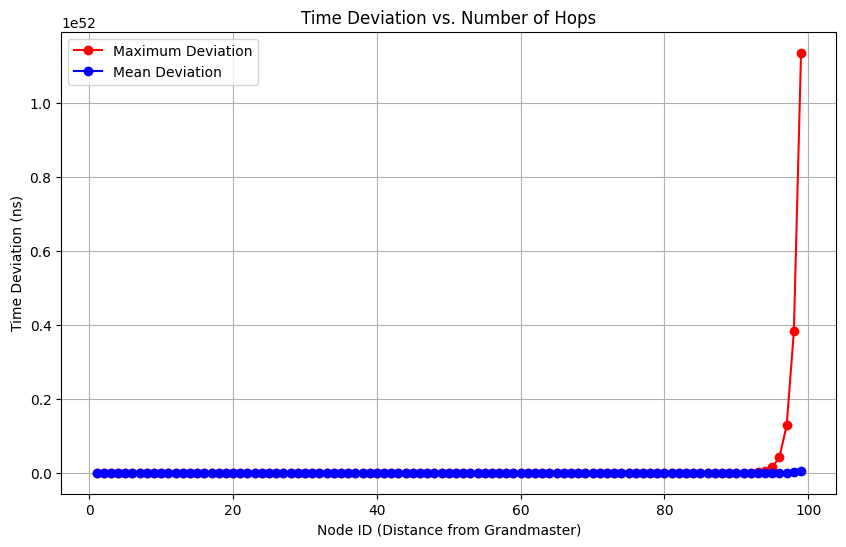

Simulation completed.


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import time

class Clock:
    """
    Clock model with drift and granularity as described in the paper.
    """
    def __init__(self, initial_drift_ppm=None, granularity_ns=8):
        # Set initial drift rate between -10 and 10 ppm if not specified
        if initial_drift_ppm is None:
            self.drift_rate_ppm = random.uniform(-10, 10)
        else:
            self.drift_rate_ppm = initial_drift_ppm
        
        # Initial drift rate (for reference)
        self.initial_drift_ppm = self.drift_rate_ppm
        
        # Initialize time to 0
        self.time = 0
        
        # Clock granularity in nanoseconds (8ns as per paper)
        self.granularity_ns = granularity_ns
        
        # Rate of change of drift rate (up to 1 ppm/s)
        self.drift_rate_change_ppm_per_s = random.uniform(0, 1)
    
    def advance(self, delta_t_s):
        """
        Advance clock by delta_t_s seconds, considering drift.
        """
        # Update drift rate due to changes over time (eq. 7-8 in paper)
        self.drift_rate_ppm += self.drift_rate_change_ppm_per_s * delta_t_s
        
        # Calculate actual time advancement with drift (eq. 6 in paper)
        actual_delta = delta_t_s * (1 + self.drift_rate_ppm / 1e6)
        
        # Add to current time
        self.time += actual_delta
        
        # Apply granularity effect
        granularity_s = self.granularity_ns / 1e9
        self.time = round(self.time / granularity_s) * granularity_s
        
        return self.time
    
    def get_time(self):
        """
        Return current time with granularity effect.
        """
        granularity_s = self.granularity_ns / 1e9
        return round(self.time / granularity_s) * granularity_s
    
    def adjust(self, offset):
        """
        Adjust clock by adding offset.
        """
        self.time += offset
        
        # Apply granularity
        granularity_s = self.granularity_ns / 1e9
        self.time = round(self.time / granularity_s) * granularity_s


class TimeAwareSystem:
    """
    Represents a time-aware system in an IEEE 802.1AS network.
    """
    def __init__(self, node_id, is_grandmaster=False):
        self.node_id = node_id
        self.is_grandmaster = is_grandmaster
        self.clock = Clock()
        
        # Propagation delay measurement
        self.propagation_delay = 0
        self.propagation_delay_measurements = deque(maxlen=10)
        
        # IEEE 802.1AS synchronization parameters
        self.correction_field = 0
        self.rate_ratio = 1.0
        self.neighbor_rate_ratio = 1.0
        
        # Sync message timestamps (tR and tS in Figure 1)
        self.t_receive = 0  
        self.t_send = 0     
        
        # For measuring synchronization precision
        self.time_deviations = []
        
        # Origin timestamp from grandmaster
        self.origin_timestamp = 0
        
        # Neighbor rate ratio measurement error (±0.1 ppm as per paper)
        self.neighbor_rate_ratio_error = random.uniform(-0.1, 0.1) / 1e6
    
    def calculate_neighbor_rate_ratio(self, neighbor_drift_rate_ppm):
        """
        Calculate neighbor rate ratio based on drift rates with error.
        Using equation (26) from the paper.
        """
        # Calculate ideal neighbor rate ratio
        ideal_ratio = (1 + neighbor_drift_rate_ppm / 1e6) / (1 + self.clock.drift_rate_ppm / 1e6)
        
        # Add error to simulate measurement inaccuracy (±0.1 ppm)
        self.neighbor_rate_ratio = ideal_ratio + self.neighbor_rate_ratio_error
        
        return self.neighbor_rate_ratio
    
    def measure_propagation_delay(self, neighbor):
        """
        Simulate propagation delay measurement as per Fig. 2 in the paper.
        """
        # Base propagation delay (50 ns for 10m copper wire)
        base_delay_ns = 50
        
        # PHY jitter for each timestamp (0-8 ns, uniformly distributed)
        phy_jitter1 = random.uniform(0, 8) / 1e9
        phy_jitter2 = random.uniform(0, 8) / 1e9
        phy_jitter3 = random.uniform(0, 8) / 1e9
        phy_jitter4 = random.uniform(0, 8) / 1e9
        
        # Simulate Pdelay_Req message (timestamps as in Fig. 2)
        t1 = self.clock.get_time()
        
        # Add propagation delay and PHY jitter for message transmission
        propagation_time = base_delay_ns / 1e9 + phy_jitter1
        
        # Advance both clocks by propagation time
        self.clock.advance(propagation_time)
        neighbor.clock.advance(propagation_time)
        
        # Neighbor receives Pdelay_Req
        t2 = neighbor.clock.get_time()
        
        # Simulate processing time in neighbor
        processing_time = random.uniform(0, 1e-6)  # Up to 1 μs
        neighbor.clock.advance(processing_time)
        self.clock.advance(processing_time)
        
        # Neighbor sends Pdelay_Resp
        t3 = neighbor.clock.get_time()
        
        # Add propagation delay and PHY jitter for response
        propagation_time = base_delay_ns / 1e9 + phy_jitter3
        
        # Advance both clocks by propagation time
        self.clock.advance(propagation_time)
        neighbor.clock.advance(propagation_time)
        
        # Receive Pdelay_Resp
        t4 = self.clock.get_time()
        
        # Calculate propagation delay using equation (4) from the paper
        measured_delay = 0.5 * ((t4 - t1) - self.neighbor_rate_ratio * (t3 - t2))
        
        # Store measurement
        self.propagation_delay_measurements.append(measured_delay)
        
        # Use cumulative average as the propagation delay value (as mentioned in paper)
        self.propagation_delay = sum(self.propagation_delay_measurements) / len(self.propagation_delay_measurements)
        
        return self.propagation_delay
    
    def receive_sync(self, origin_timestamp, correction_field, rate_ratio, neighbor_drift_rate_ppm):
        """
        Process a received Sync message and update clock based on IEEE 802.1AS.
        """
        # Record receive timestamp
        self.t_receive = self.clock.get_time()
        
        # Store origin timestamp
        self.origin_timestamp = origin_timestamp
        
        # Calculate neighbor rate ratio
        self.calculate_neighbor_rate_ratio(neighbor_drift_rate_ppm)
        
        # Update rate ratio using equation (1) from the paper
        self.rate_ratio = rate_ratio * self.neighbor_rate_ratio
        
        # Store the correction field from the received sync message
        self.correction_field = correction_field
        
        # Calculate GM time using equation (3) from the paper
        gm_time = origin_timestamp + correction_field + self.propagation_delay
        
        # Calculate time deviation before correction
        time_deviation = self.clock.get_time() - gm_time
        self.time_deviations.append(time_deviation)
        
        # Adjust clock to synchronize with grandmaster
        self.clock.adjust(-time_deviation)
        
        return time_deviation
    
    def send_sync(self):
        """
        Send a Sync message with updated time synchronization information.
        Returns the time synchronization information for the next node.
        """
        # Record send timestamp
        self.t_send = self.clock.get_time()
        
        # Update correction field using equation (2) from the paper
        residence_time = self.t_send - self.t_receive
        new_correction = self.correction_field + self.propagation_delay + (residence_time * self.rate_ratio)
        
        # Return time synchronization information
        return self.origin_timestamp, new_correction, self.rate_ratio


class IEEE8021ASSimulation:
    """
    Simulation of IEEE 802.1AS in a chain topology.
    """
    def __init__(self, num_nodes=100, sync_interval_ms=31.25, pdelay_interval_s=1):
        # Network parameters (as per paper)
        self.num_nodes = num_nodes
        self.sync_interval_s = sync_interval_ms / 1000.0
        self.pdelay_interval_s = pdelay_interval_s
        
        # Create time-aware systems
        self.nodes = []
        for i in range(num_nodes):
            is_gm = (i == 0)
            self.nodes.append(TimeAwareSystem(i, is_gm))
        
        # Results storage
        self.time_deviations = {i: [] for i in range(num_nodes)}
        
        # Store initial drift rates for analysis
        self.initial_drift_rates = [node.clock.initial_drift_ppm for node in self.nodes]
    
    def run(self, simulation_time_s=100):
        """
        Run the simulation for the specified time.
        """
        start_time = time.time()
        
        # Number of sync intervals to simulate
        num_intervals = int(simulation_time_s / self.sync_interval_s)
        
        # Number of pdelay intervals
        num_pdelay = int(simulation_time_s / self.pdelay_interval_s)
        
        print(f"Running propagation delay measurements...")
        # Run propagation delay measurements first
        for p in range(num_pdelay):
            for i in range(1, self.num_nodes):
                self.nodes[i].measure_propagation_delay(self.nodes[i-1])
                
                # Advance all clocks to keep time synchronized during measurement phase
                for node in self.nodes:
                    node.clock.advance(self.pdelay_interval_s / (self.num_nodes - 1))
        
        print(f"Running sync message propagation ({num_intervals} intervals)...")
        # Run simulation for specified time
        for interval in range(num_intervals):
            if interval % 100 == 0 and interval > 0:
                elapsed = time.time() - start_time
                print(f"Processed {interval}/{num_intervals} intervals ({elapsed:.1f}s elapsed)")
            
            # Advance all clocks by sync interval
            for node in self.nodes:
                node.clock.advance(self.sync_interval_s)
            
            # Grandmaster initiates sync
            origin_timestamp = self.nodes[0].clock.get_time()
            correction_field = 0
            rate_ratio = 1.0
            
            # Propagate sync through the network (syncLocked mode)
            for i in range(1, self.num_nodes):
                # Calculate PHY jitter for sync message (0-8 ns)
                phy_jitter = random.uniform(0, 8) / 1e9
                
                # Base propagation delay
                propagation_delay_s = 50 / 1e9  # 50 ns
                
                # Advance clocks by propagation time + jitter
                for node in self.nodes:
                    node.clock.advance(propagation_delay_s + phy_jitter)
                
                # Node receives sync
                time_deviation = self.nodes[i].receive_sync(
                    origin_timestamp,
                    correction_field,
                    rate_ratio,
                    self.nodes[i-1].clock.drift_rate_ppm
                )
                
                # Store time deviation for analysis
                self.time_deviations[i].append(time_deviation)
                
                # Node processes sync and prepares to forward (residence time)
                residence_time = random.uniform(0, 1e-3)  # Up to 1 ms as per paper
                
                # Advance clocks by residence time
                for node in self.nodes:
                    node.clock.advance(residence_time)
                
                # Node sends updated sync
                origin_timestamp, correction_field, rate_ratio = self.nodes[i].send_sync()
        
        elapsed = time.time() - start_time
        print(f"Simulation completed in {elapsed:.1f} seconds")
    
    def calculate_synchronization_probability(self, precision_threshold):
        """
        Calculate probability of synchronization within the given precision threshold.
        """
        probabilities = {}
        
        for i in range(1, self.num_nodes):
            if not self.time_deviations[i]:
                continue
            
            deviations = self.time_deviations[i]
            in_sync = sum(1 for d in deviations if abs(d) < precision_threshold)
            probability = in_sync / len(deviations)
            probabilities[i] = probability
        
        return probabilities
    
    def plot_time_deviation_distribution(self, node_ids=None):
        """
        Plot distribution of time deviations for specific nodes.
        """
        if node_ids is None:
            node_ids = [self.num_nodes - 1]  # Last node by default
        elif isinstance(node_ids, int):
            node_ids = [node_ids]
        
        plt.figure(figsize=(10, 6))
        
        for node_id in node_ids:
            # Ensure node_id is valid
            if node_id >= self.num_nodes or node_id < 0:
                print(f"Warning: Node ID {node_id} is out of range. Skipping.")
                continue
                
            if not self.time_deviations[node_id]:
                print(f"Warning: No time deviation data for node {node_id}. Skipping.")
                continue
                
            # Convert to nanoseconds for better readability
            deviations_ns = [d * 1e9 for d in self.time_deviations[node_id]]
            
            plt.hist(deviations_ns, bins=50, alpha=0.7, label=f"Node {node_id}")
            
            # Calculate statistics
            mean_dev = np.mean(deviations_ns)
            max_dev = max(abs(d) for d in deviations_ns)
            
            print(f"Node {node_id} statistics:")
            print(f"  Mean deviation: {mean_dev:.2f} ns")
            print(f"  Max absolute deviation: {max_dev:.2f} ns")
        
        plt.title("Time Deviation Distribution")
        plt.xlabel("Time Deviation (ns)")
        plt.ylabel("Frequency")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_synchronization_probability(self, precision_thresholds):
        """
        Plot synchronization probability for different precision thresholds.
        """
        plt.figure(figsize=(10, 6))
        
        for threshold in precision_thresholds:
            probs = self.calculate_synchronization_probability(threshold)
            nodes = sorted(probs.keys())
            probabilities = [probs[n] for n in nodes]
            
            # Convert threshold to ns for the label
            threshold_ns = threshold * 1e9
            plt.plot(nodes, probabilities, '-', label=f"Precision < {threshold_ns:.0f} ns")
        
        plt.title("Probability of Synchronization")
        plt.xlabel("Node ID (Distance from Grandmaster)")
        plt.ylabel("Probability")
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.show()
    
    def plot_precision_vs_hops(self):
        """
        Plot the maximum time deviation as a function of hops from grandmaster.
        """
        max_deviations = {}
        mean_deviations = {}
        
        for i in range(1, self.num_nodes):
            if not self.time_deviations[i]:
                continue
            
            # Calculate statistics in ns
            devs_ns = [abs(d) * 1e9 for d in self.time_deviations[i]]
            max_deviations[i] = max(devs_ns)
            mean_deviations[i] = np.mean(devs_ns)
        
        plt.figure(figsize=(10, 6))
        
        plt.plot(list(max_deviations.keys()), list(max_deviations.values()), 'ro-', label='Maximum Deviation')
        plt.plot(list(mean_deviations.keys()), list(mean_deviations.values()), 'bo-', label='Mean Deviation')
        
        plt.title("Time Deviation vs. Number of Hops")
        plt.xlabel("Node ID (Distance from Grandmaster)")
        plt.ylabel("Time Deviation (ns)")
        plt.legend()
        plt.grid(True)
        plt.show()


# Run the simulation
def main():
    # Create simulation with 100 nodes (as in the paper)
    num_nodes = 100
    sim = IEEE8021ASSimulation(num_nodes=num_nodes, sync_interval_ms=31.25)
    
    # Run for 100 seconds (as in the paper)
    print(f"Running simulation with {num_nodes} nodes for 100 seconds...")
    sim.run(simulation_time_s=100)
    
    # Plot results
    print("Plotting results...")
    
    # Plot time deviation distribution for node 10 and node 99 (last node)
    # Note: Nodes are 0-indexed, so the last node is num_nodes-1
    sim.plot_time_deviation_distribution([10, num_nodes-1])
    
    # Plot synchronization probability for different precision thresholds
    precision_thresholds = [0.5e-6, 1e-6, 2e-6]  # 0.5 μs, 1 μs, 2 μs
    sim.plot_synchronization_probability(precision_thresholds)
    
    # Plot precision vs number of hops
    sim.plot_precision_vs_hops()
    
    print("Simulation completed.")

if __name__ == "__main__":
    main()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

class Clock:
    def __init__(self, id, is_grandmaster=False):
        self.id = id
        self.is_grandmaster = is_grandmaster
        self.time = 0.0
        
        # Clock characteristics
        self.drift_rate = random.uniform(-10e-6, 10e-6)  # ±10 ppm
        self.drift_rate_change = 0.0  # Will change over time
        self.granularity = 8e-9  # 8 ns granularity
        
        # For neighbor rate ratio calculation
        self.last_update_time = 0.0
        self.last_corrected_time = 0.0
        
    def update(self, elapsed_time):
        # Update drift rate (slow changes up to 1 ppm/s)
        self.drift_rate_change = min(max(self.drift_rate_change + random.uniform(-1e-12, 1e-12), -1e-6), 1e-6)
        self.drift_rate = min(max(self.drift_rate + self.drift_rate_change * elapsed_time, -10e-6), 10e-6)
        
        # Update time with current drift rate
        self.time += elapsed_time * (1 + self.drift_rate)
        
        # Apply granularity effect
        self.time = np.round(self.time / self.granularity) * self.granularity
    
    def get_time(self):
        return self.time
    
    def get_drift_rate(self):
        return self.drift_rate
    
    def get_neighbor_rate_ratio(self, neighbor_clock):
        # Calculate ratio between neighbor clock and this clock
        return (1 + neighbor_clock.get_drift_rate()) / (1 + self.get_drift_rate())

class TimeAwareSystem:
    def __init__(self, id, upstream=None, downstream=None, is_grandmaster=False):
        self.id = id
        self.upstream = upstream
        self.downstream = downstream
        self.is_grandmaster = is_grandmaster
        
        # IEEE 802.1AS parameters
        self.sync_interval = 31.25e-3  # 31.25 ms sync interval
        self.pdelay_interval = 1.0  # 1 s propagation delay measurement interval
        self.sync_locked = True  # Operating in syncLocked mode
        
        # Local clock
        self.clock = Clock(id, is_grandmaster)
        
        # Time synchronization state
        self.precise_origin_timestamp = 0.0
        self.rate_ratio = 1.0  # Initial ratio (GM to self)
        self.correction_field = 0.0
        self.propagation_delay = 50e-9  # Initial estimate (50 ns for 10m copper)
        
        # Counters for simulation
        self.last_sync_time = 0.0
        self.last_pdelay_time = 0.0
        self.residence_time = random.uniform(0.5e-3, 1e-3)  # 0.5-1 ms residence time
        
        # For propagation delay measurement
        self.pdelay_req_sent_time = 0.0
        self.pdelay_resp_received_time = 0.0
        self.pdelay_resp_t2 = 0.0
        self.pdelay_resp_t3 = 0.0
        
        # PHY jitter characteristics (0-8 ns uniform)
        self.phy_jitter = lambda: random.uniform(0, 8e-9)
        
        # Track synchronization error
        self.sync_errors = []
    
    def update(self, elapsed_time):
        # Update local clock
        self.clock.update(elapsed_time)
        
        current_time = self.clock.get_time()
        
        # Grandmaster periodically sends Sync messages
        if self.is_grandmaster and (current_time - self.last_sync_time >= self.sync_interval):
            self.send_sync()
            self.last_sync_time = current_time
        
        # All systems periodically measure propagation delay
        if current_time - self.last_pdelay_time >= self.pdelay_interval:
            self.measure_propagation_delay()
            self.last_pdelay_time = current_time
    
    def send_sync(self):
        if self.downstream is None:
            return
            
        # In one-step mode, we timestamp when sending and include all info in Sync
        send_time = self.clock.get_time()
        
        # Apply PHY jitter to transmission
        send_time += self.phy_jitter()
        
        # For non-GM systems, update time synchronization info
        if not self.is_grandmaster:
            # Calculate new rate ratio (GM to self)
            neighbor_rate_ratio = self.clock.get_neighbor_rate_ratio(self.upstream.clock)
            self.rate_ratio = self.upstream.rate_ratio * neighbor_rate_ratio
            
            # Update correction field (including residence time)
            residence_time = self.residence_time
            self.correction_field = (self.upstream.correction_field + 
                                   self.upstream.propagation_delay + 
                                   residence_time * self.rate_ratio)
            
            # Add error in neighbor rate ratio (up to ±0.1 ppm)
            nr_error = random.uniform(-0.1e-6, 0.1e-6)
            neighbor_rate_ratio += nr_error
            
            # Calculate what time was at GM when we received Sync
            gm_time_at_receive = (self.precise_origin_timestamp + 
                                 self.upstream.correction_field + 
                                 self.upstream.propagation_delay)
            
            # Calculate current GM time
            current_gm_time = gm_time_at_receive + (send_time - self.last_sync_time) / self.rate_ratio
            
            # Calculate synchronization error
            sync_error = self.clock.get_time() - current_gm_time
            self.sync_errors.append(abs(sync_error))
        
        # Create Sync message (in one-step mode)
        sync_msg = {
            'type': 'sync',
            'origin_timestamp': self.precise_origin_timestamp if not self.is_grandmaster else send_time,
            'rate_ratio': self.rate_ratio,
            'correction_field': self.correction_field,
            'send_time': send_time,
            'drift_rate': self.clock.get_drift_rate()
        }
        
        # Pass to downstream system with PHY jitter
        self.downstream.receive_sync(sync_msg)
    
    def receive_sync(self, sync_msg):
        # Apply PHY jitter to reception
        receive_time = self.clock.get_time() + self.phy_jitter()
        
        # Store received time synchronization info
        self.precise_origin_timestamp = sync_msg['origin_timestamp']
        self.rate_ratio = sync_msg['rate_ratio']  # Will be updated when we send
        self.correction_field = sync_msg['correction_field']
        
        # Record when we received this for residence time calculation
        self.last_sync_time = receive_time
        
        # In syncLocked mode, send Sync immediately after receiving
        if self.sync_locked and self.downstream is not None:
            self.send_sync()
    
    def measure_propagation_delay(self):
        if self.upstream is None:
            return
            
        # Send Pdelay_Req message
        self.pdelay_req_sent_time = self.clock.get_time() + self.phy_jitter()
        self.upstream.receive_pdelay_req(self.id)
    
    def receive_pdelay_req(self, sender_id):
        # Record receive time (t2)
        t2 = self.clock.get_time() + self.phy_jitter()
        
        # Send Pdelay_Resp after some processing time (t3)
        t3 = t2 + self.residence_time
        
        # Create response message
        resp_msg = {
            'type': 'pdelay_resp',
            't2': t2,
            't3': t3,
            'drift_rate': self.clock.get_drift_rate()
        }
        
        # Send response with PHY jitter
        self.downstream.receive_pdelay_resp(resp_msg)
    
    def receive_pdelay_resp(self, resp_msg):
        # Record receive time (t4)
        t4 = self.clock.get_time() + self.phy_jitter()
        
        # Get timestamps from message
        t1 = self.pdelay_req_sent_time
        t2 = resp_msg['t2']
        t3 = resp_msg['t3']
        
        # Calculate neighbor rate ratio (with error)
        neighbor_rate_ratio = self.clock.get_neighbor_rate_ratio(self.upstream.clock)
        neighbor_rate_ratio += random.uniform(-0.1e-6, 0.1e-6)  # ±0.1 ppm error
        
        # Calculate propagation delay (including PHY jitter effects)
        self.propagation_delay = 0.5 * ((t4 - t1) - neighbor_rate_ratio * (t3 - t2))
        
        # Ensure propagation delay is positive
        self.propagation_delay = max(self.propagation_delay, 0)

def simulate_network(num_nodes=100, duration=100.0, time_step=1e-6):
    # Create network - chain topology
    grandmaster = TimeAwareSystem(0, is_grandmaster=True)
    nodes = [grandmaster]
    
    for i in range(1, num_nodes):
        new_node = TimeAwareSystem(i, upstream=nodes[-1])
        nodes[-1].downstream = new_node
        nodes.append(new_node)
    
    # Run simulation
    current_time = 0.0
    while current_time < duration:
        for node in nodes:
            node.update(time_step)
        current_time += time_step
    
    # Collect results
    sync_errors = []
    for i, node in enumerate(nodes):
        if node.sync_errors:
            avg_error = np.mean(node.sync_errors) * 1e6  # Convert to microseconds
            max_error = np.max(node.sync_errors) * 1e6
            sync_errors.append((i, avg_error, max_error))
            print(f"Node {i}: Avg sync error = {avg_error:.3f} μs, Max error = {max_error:.3f} μs")
    
    return nodes, sync_errors

# Run simulation
num_nodes = 100
sim_duration = 10.0  # seconds
nodes, sync_errors = simulate_network(num_nodes, sim_duration)

# Plot results
hops = [x[0] for x in sync_errors]
avg_errors = [x[1] for x in sync_errors]
max_errors = [x[2] for x in sync_errors]

plt.figure(figsize=(12, 6))
plt.plot(hops, avg_errors, 'b-', label='Average Sync Error')
plt.plot(hops, max_errors, 'r-', label='Maximum Sync Error')
plt.axhline(y=1.0, color='g', linestyle='--', label='1 μs target')
plt.xlabel('Number of Hops from Grandmaster')
plt.ylabel('Synchronization Error (μs)')
plt.title('IEEE 802.1AS Synchronization Quality in Large-Scale Network')
plt.legend()
plt.grid(True)
plt.show()

# Plot probability of synchronization within 1μs
prob_within_1us = [np.mean(np.array(nodes[i].sync_errors) <= 1e-6) * 100 for i in range(num_nodes)]

plt.figure(figsize=(12, 6))
plt.plot(range(num_nodes), prob_within_1us, 'b-')
plt.axvline(x=30, color='r', linestyle='--', label='30 hops')
plt.xlabel('Number of Hops from Grandmaster')
plt.ylabel('Probability of Sync Within 1μs (%)')
plt.title('Probability of Synchronization Within 1μs Precision')
plt.legend()
plt.grid(True)
plt.show()
